In [16]:
from copy import deepcopy

import numpy as np

import pandas as pd

from scipy.stats import chi2_contingency, pearsonr

import matplotlib.pyplot as plt
import seaborn as sns 

In [20]:
def compute_ssqdev(statistics):
    """
    Compute the sum of square deviations
    """
    ssqdev = 0
    for group, value in statistics.items():
        
        if group == 'grand_mean':
            continue
        else:
            ssqdev += (value - statistics['grand_mean']) ** 2
    
    return ssqdev
            
def random_sign_resampling(differences, n_resample=10000, statistic=np.median):
    """
    Apply sign resampling
    """

    differences = np.array(differences)
    sign_randomization = np.vectorize(
        lambda x: -x  if np.random.random() <= 0.5 else x
    )
    resampled_statistic = []
    for _ in range(n_resample):
        
        random_sample = sign_randomization(differences)
        resampled_statistic.append(statistic(random_sample))
    
    return resampled_statistic 

def random_group_resampling(data, groups, n_resample=10000, statistic=compute_ssqdev):
    """
    Apply group resampling
    """
    data = np.array(data)
    groups = np.array(groups)
    resampled_statistic = []
    for _ in range(n_resample):
        
        statistics = {}
        statistics['grand_mean'] = np.mean(data)
        random_groups = deepcopy(groups)
        np.random.shuffle(random_groups)
        for group in np.unique(random_groups):
            
            group_indices = np.argwhere(random_groups == group).flatten()
            statistics[group] = np.mean(data[group_indices])
        
        resampled_statistic.append(statistic(statistics))
    
    return resampled_statistic 

def random_group_resampling_count(data, groups, n_resample=10000):
    """
    Apply group resampling
    """
    data = np.array(data)
    groups = np.array(groups)
    resampled_statistic = []
    for _ in range(n_resample):
        
        random_groups = deepcopy(groups)
        np.random.shuffle(random_groups)
        contingency = pd.DataFrame()
        contingency['groups'] = random_groups
        contingency['data'] = data
        contingency = pd.crosstab(contingency['groups'], contingency['data'])
        c, p, dof, expected = chi2_contingency(contingency)
        
        resampled_statistic.append(c)
    
    return resampled_statistic 

def bootstrap_statistic(data, n_resample=10000, statistic=np.median):
    """
    Apply bootstrap
    """
    data = np.array(data)
    resampled_statistic = []
    for _ in range(n_resample):
        
        resampled_statistic.append(
            statistic(np.random.choice(data, len(data)))
        )
    
    return resampled_statistic

def resample_corr(x, y, n_resample=10000):
    """
    Apply bootstrap to correlation
    """
    x = np.array(x)
    y = np.array(y)
    resampled_corr = []
    for _ in range(n_resample):
        
        resampled_corr.append(
            pearsonr(np.random.choice(x, len(x)), y)[0]
        )
    
    return resampled_corr

def plot_resampled(resampled, observed):
    """
    Plot resampled statistic and observed one
    """
    plt.figure(figsize=(5, 5))
    sns.histplot(resampled)
    plt.axvline(observed, c='r')
    plt.xlabel('Distribution Resampled')
    plt.show()
    return None

def plot_bootstrapped(bootstrapped, observed):
    """
    Plot bootstrapped statistic with CI and oberved one
    """
    upper = np.percentile(bootstrapped, 92.5)
    lower = np.percentile(bootstrapped, 2.5)
    
    plt.figure(figsize=(5, 5))
    sns.histplot(bootstrapped)
    plt.axvline(observed, c='r')
    plt.axvline(lower, c='r', linestyle='--', alpha=0.5)
    plt.axvline(upper, c='r', linestyle='--', alpha=0.5)
    plt.xlabel('Distribution Bootstrapped')
    plt.show()
    return None

# Class Examples

### One-way within-subjects design

These are data taken from Howell chapter 18, see the lecture slides for a full description the differences are endorphin levels in patients just before surgery (high stress) minus the endorphin levels 12 hours after surgery (low stress).

In [39]:
diffs = [10, 7.5, 5.5, 6, 9.5, -2.5, 13, 3, -0.1, 0.2, 20.3, 4, 8, 25, 7.2, 35, -3.5, -1.9, 0.1]

Is there a majority of diffs which fall one side or other of zero?  
One way from removing any effect here is to randomly swap the sign of the difference.

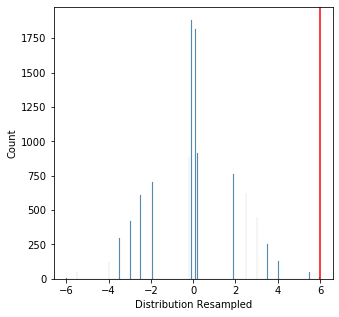

In [88]:
resampled_median = random_sign_resampling(diffs)
plot_resampled(resampled_median, np.median(diffs))

### One-way between-subjects design

In [89]:
data = np.array([18, 9, 15, 10, 16, 8, 7, 20, 13,  8, 12, 
        17, 13,  9,  8, 10, 13, 16, 17, 12, 11, 17, 
        15, 13, 13, 14, 15, 20, 15, 14, 9, 16, 12, 
        16, 12, 13, 12, 14, 11, 8, 13, 17, 15, 14])
groups = np.array([1]*11 + [2]*11 + [3]*11 + [4]*11)

One possibility here is to randomize without replacement the groups labels

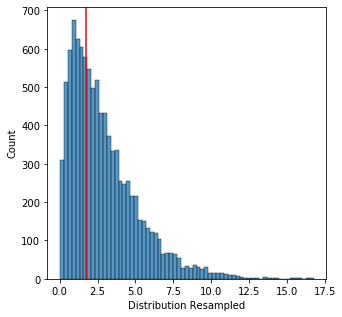

In [90]:
resampled_ssqdev = random_group_resampling(
    data=data, 
    groups=groups
)
observed_statistics = {
    'grand_mean': np.mean(data)
}
for group in np.unique(groups):

    group_indices = np.argwhere(groups == group).flatten()
    observed_statistics[group] = np.mean(data[group_indices])

observed_ssqdev = compute_ssqdev(observed_statistics)
plot_resampled(resampled_ssqdev, observed_ssqdev)

### Two groups with binary outcomes

Column 1 is smoker 1 or not 2. Column 2 is parkinson's disease yes 1 or not 0.

In [32]:
data=np.array(
    [
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [2, 1],
        [2, 1],
        [2, 1],
        [2, 1],
        [2, 1],
        [2, 1],
        [2, 0],
        [2, 0]
    ]
)

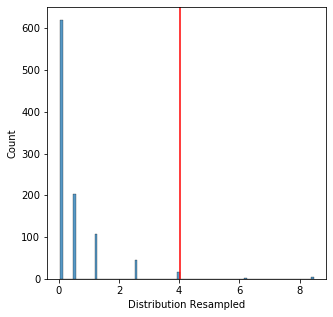

In [33]:
contingency = pd.DataFrame(
    data=data,
    columns=['smoking', 'parkinson']
)
contingency = pd.crosstab(contingency['smoking'], contingency['parkinson'])
observed_c, p, dof, expected = chi2_contingency(contingency)

resampled_c = random_group_resampling_count(data[:, 0], data[:, 1], n_resample=1000)

plot_resampled(resampled_c, observed_c)

### Bootstrap

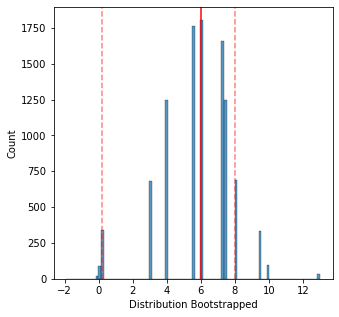

In [47]:
boostrapped_median = bootstrap_statistic(diffs)
plot_bootstrapped(boostrapped_median, np.median(diffs))

We have data from 20 particiapnts for whom we record the level of testosterone and age

In [5]:
testo = [20, 21, 19, 18, 51, 37, 68, 28, 52, 18, 19, 50, 43, 13, 19, 23, 27, 31, 37, 31]
age =   [43, 38, 36, 35, 29, 27, 27, 26, 25, 58, 25, 22, 19, 44, 34, 30, 29, 26, 25, 22]

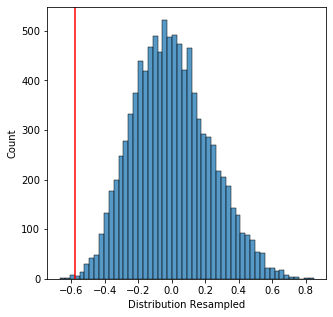

In [21]:
resampled_corr = bootstrap_corr(testo, age)
plot_resampled(resampled_corr, pearsonr(testo, age)[0])